In [32]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

In [33]:
DS1 = "./csv/convert/capture1_1.csv"
DSMERGED = "./csv/convert/capture_merge_1.csv"
LOG = "./csv/convert/conn.log.labeled"
# turn this to true, to skip all unnecessary fields
FAST = True

# Datensatzauswahl

Welche Datensätze haben wir in betracht gezogen und warum haben wir uns für diesen entschieden?

# Vorstellung der .log files und deren Struktur 
### Beispielhaft für Datensatz 1

In [34]:
fields=["ts","uid","orig_h","orig_p","resp_h","resp_p","proto","service","duration","orig_bytes","resp_bytes","conn_state","local_orig","local_resp","missed_bytes","history","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes","tunnel_parents","label","detailed-label"]

df_raw_log = pd.read_csv(LOG,skipfooter=1, engine="python", names=fields, sep="\x09|\x20\x20\x20", skiprows=8)
df_raw_log = df_raw_log.replace('-', np.nan)


In [35]:
if not FAST:
    pd.set_option('display.max_columns', None)
    df_raw_log.head()

### Spaltenübersicht

<div style="tposition>
    
| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |
</div>

In [36]:
if not FAST:
    df_raw_log.columns

In [37]:
if not FAST:
    df_raw_log.isna().sum()

| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |


## Encoding der Spalten

In [38]:
protos = list(df_raw_log.proto.unique().flatten())
conn_states = list(df_raw_log.conn_state.unique().flatten())
histories = list(df_raw_log.history.unique().flatten())
def convert_ipv4(addr):
    """Konvertieren einer IPv4 Adresse zu einem INT"""
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def con_proto(proto):
    """Konvertieren der Ports ICMP, TCP und UDP zu einem INT"""
    return protos.index(proto)

def convert_connstate(state):
    return conn_states.index(state)

def convert_histories(history):
    return histories.index(history)
        

### Konvertieren des DataFrames in ein normiertes Format
1. Konvertieren der IPv4 Spalten
2. Konvertieren der Protokoll Spalte
3. Löschen der ts und uid spalten

In [39]:
def norm_df(df):
    """
    Normierung des DataFrames, dh löschen der Spalten, welche nicht gebraucht werden und konvertieren der object Spalten zu INT
    """
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    df['proto'] = df['proto'].apply(con_proto)
    df['conn_state'] = df['conn_state'].apply(convert_connstate)
    df['history'] = df['history'].apply(convert_histories)
    df = df.drop(['uid', 'ts', 'tunnel_parents', 'detailed-label', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp'], axis=1)
    df['label'] = (df['label'] == "Malicious").astype(int)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [40]:
df_conversion_1 = norm_df(df_raw_log)

In [41]:
if not FAST:
    df_conversion_1.dtypes

In [42]:
if not FAST:
    df_conversion_1.head(20)

In [43]:
if not FAST:
    df_conversion_1.label.value_counts()

In [44]:
def viz(df):
    for c, label in enumerate(df.columns):
        counts, edges, bars = plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=True, stacked=True)
        counts2, edges2, bars2 = plt.hist(df[df["label"] ==  0][label], color='red', label='Benign', alpha=0.7, density=True, stacked=True)
        plt.title(label)
        plt.ylabel("probability density")
        plt.xlabel(label)
        plt.legend()
        plt.show()

In [45]:
if not FAST:
    viz(df_conversion_1)

## Scatter plot der Daten

In [46]:
def make_bytes_plot(df) -> plt.figure:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='label', ax=ax1)
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='proto', ax=ax3)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='label', ax=ax2)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='proto', ax=ax4)
    plt.show()
    return fig

In [47]:
if not FAST:
    make_bytes_plot(df_conversion_1)

# Konvertierung eines .log files in eine CSV

In [48]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [49]:
df_ds1

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,59686,1159721954,8080,1,1
1,3232261223,43763,3663581508,47061,2,0
2,3232261223,51353,2712346730,2323,1,1
3,3232261223,43763,2028023405,39377,2,0
4,3232261223,45543,987512794,23,1,1
...,...,...,...,...,...,...
1008740,3232261223,44552,873217422,2323,1,1
1008741,3232261223,52111,3145280628,23,1,1
1008742,3232261223,56553,593749694,2323,1,1
1008743,3232261223,48087,716058614,8080,1,1


In [50]:
df_dsmerged

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,43763,3663581508,47061,2,0
1,3232261223,43763,2028023405,39377,2,0
2,3232261223,43763,2713856255,20457,2,0
3,3232261223,43763,1066870262,16504,2,0
4,3232261223,43763,3798348164,37327,2,0
...,...,...,...,...,...,...
2123247,3232235972,3372,908547944,992,1,1
2123248,3232235972,30751,3512843912,80,1,1
2123249,3232235972,16764,908547944,992,1,1
2123250,3232235972,4020,3512843912,80,1,1


---

# Klassifizierung der Daten mit DBSCAN und HDBSCAN

## Beispielhaft für Datensatz 1

In [51]:
def dbscanner(df, title):
    dbscan = DBSCAN(eps=8, min_samples=4).fit(df)
    labels=dbscan.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

In [52]:
def hdbscanner(df, title):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

In [53]:
if not FAST:
    dbscanner(df_conversion_1, "dbscan")
    hdbscanner(df_conversion_1, "hdbscan")

---

# Mergen der dateien 1, 7, 35

In [54]:
def merge(datasets):
  df_return = pd.DataFrame()
  for d in datasets:
    df = pd.read_csv(f"./csv/convert/capture{d}_1.csv")
    print(f"====\nDF{d}")
    print(f"shape before: {df.shape}")
    print(f"labels before:\n\t1:: {len(df[df['label'] == 1])}\n\t0:: {len(df[df['label'] == 0])}")
    l_dfs = [df[df['label'] == 0], df[df['label'] == 1]]
    for label in [0,1]:
      if len(l_dfs[label]) > 500_000:
        percent = 500_000 / len(l_dfs[label])
        print(f"cut {1-percent} off label == {label}")
        l_dfs[label] = np.array_split(l_dfs[label].sample(frac=1), 1/percent)[0]
    df = pd.concat(l_dfs, ignore_index=1)
    df_return = pd.DataFrame(pd.concat([df_return,df],ignore_index = True))
  print("=== now changing the df_return ===")
  ones = len(df_return[df_return['label'] == 1])
  zeros = len(df_return[df_return['label'] == 0])
  thebigger = 1 if ones > zeros else 0
  perc = zeros / ones
  print("shape before: ")
  print(df_return["label"].value_counts())
  print(f"ratio: {perc}")
  perc =  1 - perc if perc > 1 else perc
  print(f"cut_perc {perc}")
  l_dfs = [df_return[df_return['label'] == 0], df_return[df_return['label'] == 1]]
  rows_to_cut = int(len(l_dfs[thebigger]) * perc)
  l_dfs[thebigger] = l_dfs[thebigger].iloc[:rows_to_cut]
  df_return = pd.concat(l_dfs)
  print("===\nshape after: ")
  print(df_return["label"].value_counts())
  print(f"shape: {df_return.shape}")
  return df_return

In [55]:
if not FAST:
    ids = [1,7,35]
    df = merge(ids)

====
DF1
shape before: (1008745, 7)
labels before:
	1:: 539471
	0:: 469274
cut 0.07316612014362223 off label == 1
====
DF7
shape before: (11454711, 7)
labels before:
	1:: 11378759
	0:: 75952
cut 0.95605847702724 off label == 1
====
DF35
shape before: (10447784, 7)
labels before:
	1:: 2185396
	0:: 8262388
cut 0.9394848075399025 off label == 0
cut 0.7712085132397057 off label == 1
=== now changing the df_return ===
shape before: 
label
1    1603037
0    1061626
Name: count, dtype: int64
ratio: 0.6622591992574095
cut_perc 0.6622591992574095
===
shape after: 
label
0    1061626
1    1061626
Name: count, dtype: int64
shape: (2123252, 7)


---

# Training der Datensätze

## Split in Training, Validierung und Trainingsdatensatz, Oversampling

In [56]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [57]:
def split(df):
    # train sind 60%, valid und test sind jeweils 20%
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [58]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

## Datensatz 1

In [72]:
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

### kNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
from sklearn.model_selection import GridSearchCV

grid_params = {
'n_neighbors': range(1,15),
'weights': ['uniform', 'distance'],
'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', 'manhattan', 'nan_euclidean'],
'algorithm': ['ball_tree', 'kd_tree'],
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv = 2,     # Determines the cross-validation splitting strategy
                # integer, to specify the number of folds
    n_jobs = -1 # use all processors to perform the model
)

gs_results = gs.fit(X_train, y_train)

Fitting 2 folds for each of 448 candidates, totalling 896 fits


/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
336 fits failed out of a total of 896.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/neighbo

In [67]:
knn_model = KNeighborsClassifier(n_neighbors=4, algorithm="ball_tree", weights="distance", metric="euclidean", n_jobs=-1)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
ps = precision_score(y_valid, y_pred)
rs = recall_score(y_valid, y_pred)
print(rs)
print(ps)

0.5396134279030042
0.5353984746324748


In [66]:
gs_results.best_params_

{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_neighbors': 4,
 'weights': 'distance'}

<Axes: >

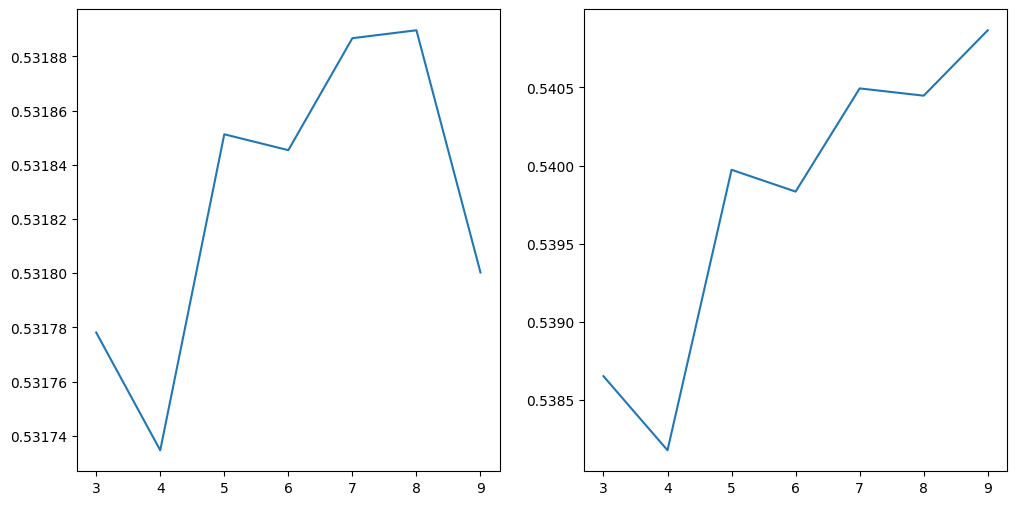

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.lineplot(x=range(3,10),y=pss, ax=ax1)
sns.lineplot(x=range(3,10),y=rss, ax=ax2)

<function matplotlib.pyplot.show(close=None, block=None)>

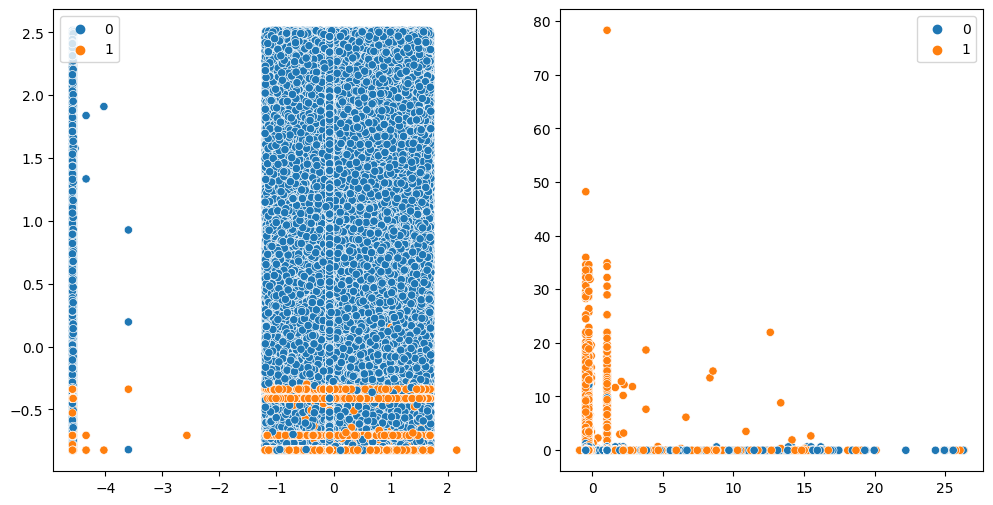

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.scatterplot(x=pd.DataFrame(X_valid)[1].values, y=pd.DataFrame(X_test)[3].values, hue=y_pred, ax=ax1)
sns.scatterplot(x=pd.DataFrame(X_valid)[9].values, y=pd.DataFrame(X_test)[11].values, hue=y_pred, ax=ax2)
plt.show

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46     93505
           1       0.54      0.54      0.54    108245

    accuracy                           0.50    201750
   macro avg       0.50      0.50      0.50    201750
weighted avg       0.50      0.50      0.50    201750



### bTrees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# https://towardsdatascience.com/random-forest-classification-678e551462f5?gi=ac29a94cba92

#m_f = 3,  max_depth = 4, max_features = 5, random_state = 18

# hyperparameter optimierung
clf = RandomForestClassifier(n_estimators = 1000, bootstrap = True)

# n_estimators — the number of decision trees you will be running in the model
# max_depth — this sets the maximum possible depth of each tree
# max_features — the maximum number of features the model will consider when determining a split
# bootstrapping — the default value for this is True, meaning the model follows bootstrapping principles (defined earlier).
# max_samples — This parameter assumes bootstrapping is set to True, if not, this parameter doesn’t apply. In the case of True, this value sets the largest size of each sample for each tree.
# Other important parameters are criterion, min_samples_split, min_samples_leaf, class_weights, n_jobs, and others that can be read in the sklearn’s RandomForestClassifier documentation here.



In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
# Create our predictions
prediction = clf.predict(X_test)
# Create confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
confusion_matrix(y_test, prediction)

array([[ 93958,     22],
       [104233,   3537]])

In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.47      1.00      0.64     93980
           1       0.99      0.03      0.06    107770

    accuracy                           0.48    201750
   macro avg       0.73      0.52      0.35    201750
weighted avg       0.75      0.48      0.33    201750



### aNN

```python
# Use scikit-learn to grid search the number of neurons
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1, activation='relu'):
    # create model
    ann = Sequential()
    ann.add(Dense(units = neurons, activation = activation))
    ann.add(Dense(units = 1)
    # Compile model
    ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return ann
# fix random seed for reproducibility
np.random.seed(0)
# create model
ann = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 10, verbose = 0)
# define the grid search parameters
parameters = {'neurons': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']}
grid = GridSearchCV(estimator = ann, param_grid = parameters, n_jobs = -1, cv=3)
grid_result = grid.fit(X1_train, y1_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Datensatz merged

In [73]:
train, valid, test = split(df_dsmerged)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

n_neighbors = 3
X = X_train
y = y_train

In [ ]:
#### Hyperparameter Optimierung n_neighbors kNN

In [ ]:
k_values = [i for i in range (1,15)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Crossvaldation 
    '''
    The cross_val_score() function automatically splits the available data into k contiguous subsets (folds), where k is the desired number of folds. 
    It then trains and tests the model k times, using a different fold as the test dataset each time and the remaining folds for training.
    '''
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
    print(f"finished {k}")

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
# TODO Knn mit 2 + Visualisierung
n_neighbors = 2
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_train, y_train)

### bTrees

### Random Forest

### aNN

In [74]:
import tensorflow as tf

In [75]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()




In [79]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes <= 128, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(5,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


In [80]:
# 64 nodes, dropout_prob 0.2, lr 0.001, batch size 64
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
nodes = 64
dropout_prob = 0.2
lr = 0.001
batch_size = 64
model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
plot_nn(history=history)
val_loss = model.evaluate(X_test, y_test)[0]
if val_loss < least_val_loss:
    least_val_loss = val_loss
    least_loss_model = model

### DTrees

In [ ]:
# Imports
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

In [ ]:
X_train

array([[ 0.09279745, -0.61443018, -0.46753735, -0.82098792, -0.74261529],
       [ 0.09279745,  0.22335303, -0.93744183, -0.82098792, -0.74261529],
       [ 0.09279745, -0.06991768,  0.65787687,  0.9584615 ,  1.17526041],
       ...,
       [ 0.09279745, -0.06991768, -1.56380457,  2.24640452,  1.17526041],
       [ 0.09279745, -0.06991768,  0.20118089,  2.3347101 ,  1.17526041],
       [ 0.09279745, -0.06991768, -1.48024742,  1.71161407,  1.17526041]])

In [ ]:
# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
#Predict the response for test dataset
y_pred = dtree.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# show difference between tree that doesn't have stopping criteria and the one that does
dtree.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.46578173869511125

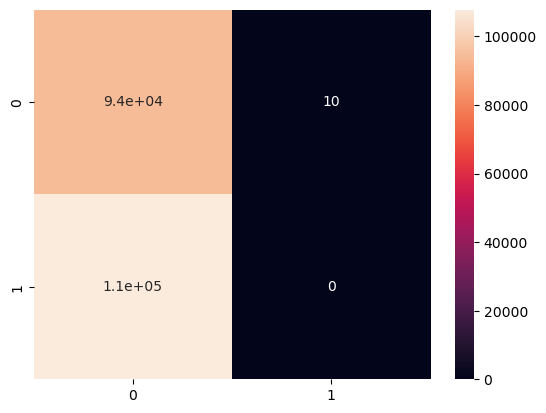

In [ ]:
# Confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm,annot=True)
plt.savefig('img/dtree_confusion.png')